## 1. Loading data

### 1.1. Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
import torch
import torch.nn as nn
import seaborn as sns
import math
import calendar
from sklearn.metrics import mean_squared_error
import pytorch_lightning as pl
import warnings
warnings.filterwarnings("ignore")

C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

## 2. Preparing data for analysis

### 2.1. Data preprocessing

In [2]:
df = pd.read_excel('2019-2020.xlsx', skiprows=2)

In [3]:
df

,data obrotu,data dostawy,godzina dostawy,kurs fixingu I (PLN/MWh),wolumen fixingu I (MWh),kurs fixingu II (PLN/MWh),wolumen fixingu II (MWh),kurs notowan ciaglych (PLN/MWh),wolumen notowan ciaglych (MWh)
0,2019-01-01,2019-01-02,1,40.00,4021.5,19.85,1372.6,20.00,34.50
1,2019-01-01,2019-01-02,2,31.00,3950.2,2023-09-01 00:00:00,1389.6,10.00,2020-10-29 00:00:00
2,2019-01-01,2019-01-02,3,31.00,3951.8,2020-01-05 00:00:00,1345.9,1959-09-01 00:00:00,39.40
3,2019-01-01,2019-01-02,4,31.00,3991.2,1988-09-01 00:00:00,1434.5,1959-09-01 00:00:00,39.40
4,2019-01-01,2019-01-02,5,31.00,4035.3,1993-09-01 00:00:00,1451.8,10.00,19.30
...,...,...,...,...,...,...,...,...,...
17419,2020-12-25,2020-12-26,20,195.00,3208.2,NaN,NaN,NaN,NaN
17420,2020-12-25,2020-12-26,21,186.03,2951.0,NaN,NaN,NaN,NaN
17421,2020-12-25,2020-12-26,22,174.75,2774.2,NaN,NaN,NaN,NaN
17422,2020-12-25,2020-12-26,23,142.73,2971.2,NaN,NaN,NaN,NaN


In [4]:
df.head(10).style.set_table_styles(
[{'selector': 'th',
  'props': [('background', '#008080'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 {'selector': 'td',
  'props': [('font-family', 'verdana'),
            ('color', 'black')]},

 {'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#DCDCDC')]}, 
 
  {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 
  {'selector': 'tr:hover',
  'props': [('background', 'yellow')]},
]).hide_index()

data obrotu,data dostawy,godzina dostawy,kurs fixingu I (PLN/MWh),wolumen fixingu I (MWh),kurs fixingu II (PLN/MWh),wolumen fixingu II (MWh),kurs notowan ciaglych (PLN/MWh),wolumen notowan ciaglych (MWh)
2019-01-01 00:00:00,2019-01-02 00:00:00,1,40.000000,4021.500000,19.85,1372.600000,20.00,34.50
2019-01-01 00:00:00,2019-01-02 00:00:00,2,31.000000,3950.200000,2023-09-01 00:00:00,1389.600000,10.00,2020-10-29 00:00:00
2019-01-01 00:00:00,2019-01-02 00:00:00,3,31.000000,3951.800000,2020-01-05 00:00:00,1345.900000,1959-09-01 00:00:00,39.40
2019-01-01 00:00:00,2019-01-02 00:00:00,4,31.000000,3991.200000,1988-09-01 00:00:00,1434.500000,1959-09-01 00:00:00,39.40
2019-01-01 00:00:00,2019-01-02 00:00:00,5,31.000000,4035.300000,1993-09-01 00:00:00,1451.800000,10.00,19.30
2019-01-01 00:00:00,2019-01-02 00:00:00,6,45.000000,4210.700000,26.41,1478.400000,20.00,1970-07-01 00:00:00
2019-01-01 00:00:00,2019-01-02 00:00:00,7,108.500000,3822.300000,189.24,1017.200000,-,-
2019-01-01 00:00:00,2019-01-02 00:00:00,8,175.070000,5218.100000,213.27,1041.300000,-,-
2019-01-01 00:00:00,2019-01-02 00:00:00,9,197.940000,4519.800000,214.63,715.000000,-,-
2019-01-01 00:00:00,2019-01-02 00:00:00,10,201.980000,3911.200000,217.98,657.400000,218.00,9.00


In [5]:
df.shape

(17424, 9)

In [6]:
df['godzina dostawy'].isnull().sum()

0

In [7]:
df['godzina dostawy'] = pd.to_numeric(df['godzina dostawy'], errors='coerce')
df['date'] = pd.to_datetime(df['data dostawy']) + pd.to_timedelta(df['godzina dostawy'], unit='h')

df = pd.DataFrame(data={'date': df['date'], 'fixing I course (PLN/MWh)':df['kurs fixingu I (PLN/MWh)']})
df['month'] = pd.DatetimeIndex(df['date']).month
df['month_name'] = pd.to_datetime(df['month'], format='%m').dt.month_name()
df['hour'] = df.date.dt.hour
df['week'] = pd.to_datetime(df['date']).dt.week
df['date_normalize'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d') 
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
df['day_of_month'] = pd.to_datetime(df['date_normalize']).dt.day
df['md'] = pd.to_datetime(df['date']).dt.strftime('%m-%d') 

In [8]:
def season_of_date(date):
    
    seasons = {'spring': pd.date_range(start='2019-03-21', end='2019-06-20').strftime('%m-%d'),
               'summer': pd.date_range(start='2019-06-21', end='2019-09-22').strftime('%m-%d'),
               'autumn': pd.date_range(start='2019-09-23', end='2019-12-20').strftime('%m-%d')}
    if date in seasons['spring']:
        return 'Spring'
    if date in seasons['summer']:
        return 'Summer'
    if date in seasons['autumn']:
        return 'Autumn'
    else:
        return 'Winter'

In [9]:
df['season'] = df.md.map(season_of_date)

In [10]:
# names of months in Polish for charts for the diploma thesis
def polish_label_r(row):
    if row['month_name'] == 'January':
        return 'Styczeń'
    if row['month_name'] == 'February':
        return 'Luty'
    if row['month_name'] == 'March':
        return 'Marzec'
    if row['month_name'] == 'April':
        return 'Kwiecień'
    if row['month_name'] == 'May':
        return 'Maj'
    if row['month_name'] == 'June':
        return 'Czerwiec'
    if row['month_name'] == 'July':
        return 'Lipiec'
    if row['month_name'] == 'August':
        return 'Sierpień'
    if row['month_name'] == 'September':
        return 'Wrzesień'
    if row['month_name'] == 'October':
        return 'Październik'
    if row['month_name'] == 'November':
        return 'Listopad'
    if row['month_name'] == 'December':
        return 'Grudzień'


In [11]:
df['pl_month_name'] = df.apply(lambda row: polish_label_r(row), axis=1)

In [12]:
df2019 = df[df['date']<'2020-01-01 00:00:00'].reset_index(drop=True)
df2020 = df[df['date']>='2020-01-01 00:00:00'].reset_index(drop=True)


In [13]:
df2019_monthly = df2019.groupby(['month_name']).agg({'fixing I course (PLN/MWh)':['mean', 'std']}).reset_index()
df2020_monthly = df2020.groupby(['month_name']).agg({'fixing I course (PLN/MWh)':['mean', 'std']}).reset_index()

df2019_monthly = df2019_monthly.rename(columns={"fixing I course (PLN/MWh)": "fixing I course 2019"}) 
df2020_monthly = df2020_monthly.rename(columns={"fixing I course (PLN/MWh)": "fixing I course 2020"}) 

df_fx_monthly = pd.merge(df2019_monthly, df2020_monthly, how='inner', on=['month_name']) 

In [14]:
cats = ["January", "February", "March", "April", "May", 
        "June", "July", "August", "September", "October", "November", "December"]
df_fx_monthly['month_name'] = pd.Categorical(df_fx_monthly['month_name'], categories=cats, ordered=True)
df_fx_monthly = df_fx_monthly.sort_values('month_name').reset_index(drop=True)

In [15]:
df_fx_monthly

month_name fixing I course 2019            fixing I course 2020           
                              mean        std                 mean        std
0     January           246.159666  61.076298           191.011062  43.146024
1    February           214.887188  41.679537           176.725517  52.982464
2       March           199.216326  39.305834           165.831844  46.175310
3       April           227.157708  41.537521           151.707708  29.625892
4         May           240.303602  41.354861           172.192137  31.405487
5        June           250.604653  54.178740           217.278208  33.618817
6        July           239.451022  43.920551           222.505618  24.483365
7      August           267.395685  35.212064           231.319597  36.808373
8   September           243.292347  38.327626           242.856528  42.755387
9     October           229.913199  40.728084           240.093992  45.131155
10   November           215.854097  38.477430           243.809625  51.683986
11   December           189.271398  47.748601           261.839753  74.304640

### 2.2. Checking outliers 

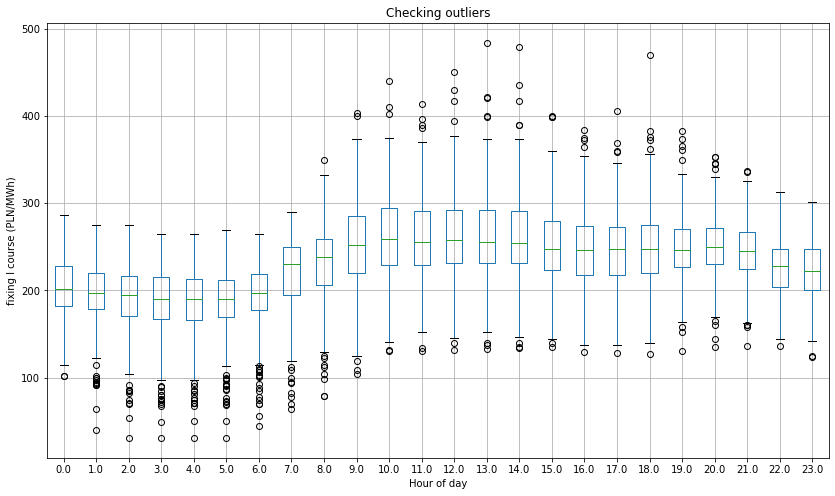

In [16]:
# box-plot to check outliers in individual hours for 2019
outpoints_hourly_2019 = df2019.pivot_table(index='date_normalize', 
                     columns=df2019['hour'], 
                     values='fixing I course (PLN/MWh)', 
                     aggfunc='mean').boxplot(figsize=(14,8)).set(title = "Checking outliers", xlabel = "Hour of day", ylabel = "fixing I course (PLN/MWh)")

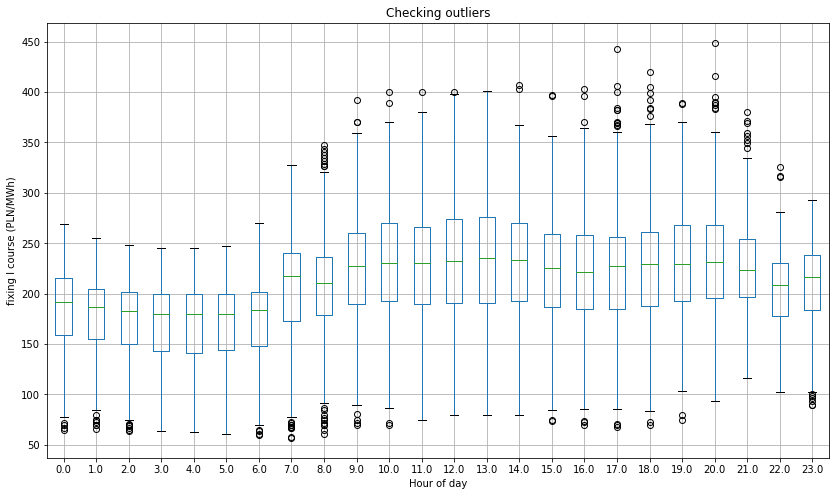

In [17]:
# box-plot to check outliers in individual hours for 2020
outpoints_hourly_2020 = df2020.pivot_table(index='date_normalize', 
                     columns=df2020['hour'], 
                     values='fixing I course (PLN/MWh)', 
                     aggfunc='mean').boxplot(figsize=(14,8)).set(title = "Checking outliers", xlabel = "Hour of day", ylabel = "fixing I course (PLN/MWh)")

In [18]:
df2019.to_excel("data_2019.xlsx")  
df2020.to_excel("data_2020.xlsx")  

## 3. Exploratory data analysis

In [19]:
df2019_monthly = df2019.groupby(['month_name']).agg({'fixing I course (PLN/MWh)':['mean', 'std']}).reset_index()
df2020_monthly = df2020.groupby(['month_name']).agg({'fixing I course (PLN/MWh)':['mean', 'std']}).reset_index()

In [20]:
df2019_monthly = df2019_monthly.rename(columns={"fixing I course (PLN/MWh)": "fixing I course 2019"}) 
df2020_monthly = df2020_monthly.rename(columns={"fixing I course (PLN/MWh)": "fixing I course 2020"}) 

In [21]:
df_fx_monthly = pd.merge(df2019_monthly, df2020_monthly, how='inner', on=['month_name']) 

In [22]:
cats = ["January", "February", "March", "April", "May", "June", 
        "July", "August", "September", "October", "November", "December"]
df_fx_monthly['month_name'] = pd.Categorical(df_fx_monthly['month_name'], categories=cats, ordered=True)
df_fx_monthly = df_fx_monthly.sort_values('month_name').reset_index(drop=True)

In [23]:
df_fx_monthly.columns = df_fx_monthly.columns.get_level_values(0)

In [24]:
df_fx_monthly.columns.values[1] = "fixing I course 2019_mean"
df_fx_monthly.columns.values[2] = "fixing I course 2019_std"
df_fx_monthly.columns.values[3] = "fixing I course 2020_mean"
df_fx_monthly.columns.values[4] = "fixing I course 2020_std"

In [25]:
df_fx_monthly['pl_month_name'] = df_fx_monthly.apply(lambda row: polish_label_r(row), axis=1)

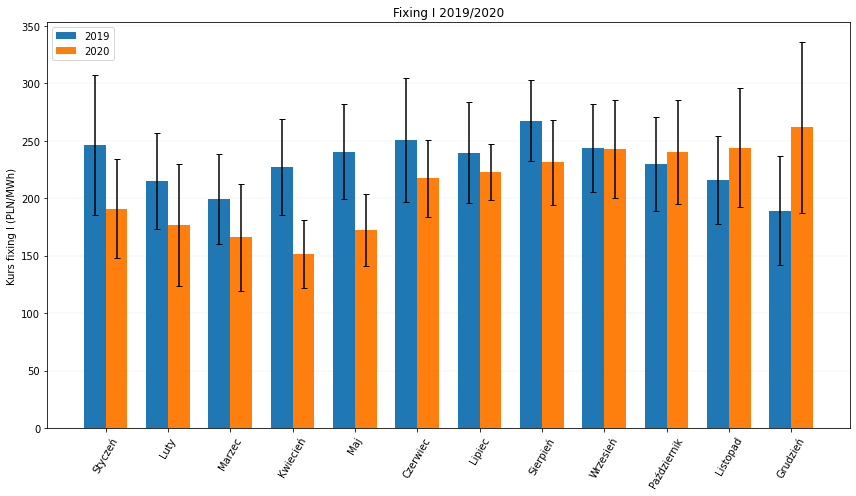

In [26]:
ind = np.arange(len(df_fx_monthly['fixing I course 2019_mean']))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(
figsize=(12,7))
rects1 = ax.bar(ind - width/2, df_fx_monthly['fixing I course 2019_mean'] , width, yerr=df_fx_monthly['fixing I course 2019_std'],
                label='2019', capsize=3)
rects2 = ax.bar(ind + width/2, df_fx_monthly['fixing I course 2020_mean'], width, yerr=df_fx_monthly['fixing I course 2020_std'],
                label='2020', capsize=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Kurs fixing I (PLN/MWh)')
ax.set_title('Fixing I 2019/2020')
ax.set_xticks(ind)
ax.set_xticklabels(df_fx_monthly['pl_month_name'], rotation=60)
ax.grid(color='grey', linestyle='-', linewidth=0.15, alpha=0.5, axis = 'y')
ax.legend()


fig.tight_layout()

plt.show()

### 3.1. Data visualization using Plotly library

In [27]:
df2020

,date,fixing I course (PLN/MWh),month,month_name,hour,week,date_normalize,day_of_week,day_of_month,md,season,pl_month_name
0,2020-01-01 00:00:00,144.85,1.0,January,0.0,1.0,2020-01-01,2.0,1.0,01-01,Winter,Styczeń
1,2020-01-01 01:00:00,134.40,1.0,January,1.0,1.0,2020-01-01,2.0,1.0,01-01,Winter,Styczeń
2,2020-01-01 02:00:00,127.80,1.0,January,2.0,1.0,2020-01-01,2.0,1.0,01-01,Winter,Styczeń
3,2020-01-01 03:00:00,118.43,1.0,January,3.0,1.0,2020-01-01,2.0,1.0,01-01,Winter,Styczeń
4,2020-01-01 04:00:00,109.85,1.0,January,4.0,1.0,2020-01-01,2.0,1.0,01-01,Winter,Styczeń
...,...,...,...,...,...,...,...,...,...,...,...,...
8683,2020-12-26 20:00:00,195.00,12.0,December,20.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Grudzień
8684,2020-12-26 21:00:00,186.03,12.0,December,21.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Grudzień
8685,2020-12-26 22:00:00,174.75,12.0,December,22.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Grudzień
8686,2020-12-26 23:00:00,142.73,12.0,December,23.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Grudzień


In [28]:
df_fx_hourly = df2020.groupby(['hour']).agg({'fixing I course (PLN/MWh)':np.mean})
df_fx_hourly = df_fx_hourly.reset_index() 

In [29]:
df_fx_hourly['h-m']=df2020['date'].astype(str).str[11:16]

In [30]:
df_fx_hourly['fixing I course (PLN/MWh)'][0] = df_fx_hourly['fixing I course (PLN/MWh)'][1]

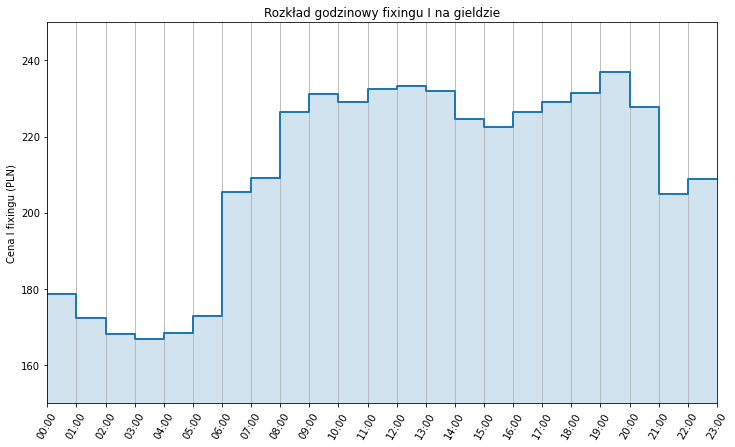

In [31]:
fig = plt.subplots(figsize=(12,7))

plt.plot(df_fx_hourly['h-m'], df_fx_hourly['fixing I course (PLN/MWh)'], ls='steps',
        linewidth=2.0)
plt.fill_between(df_fx_hourly['h-m'],df_fx_hourly['fixing I course (PLN/MWh)'], step="pre", alpha=0.2)
plt.title('Rozkład godzinowy fixingu I na gieldzie')
plt.grid(color='grey', linestyle='-', linewidth=0.15, alpha=0.5, axis = 'y')
plt.xticks(df_fx_hourly['h-m'], rotation=60)
plt.ylabel("Cena I fixingu (PLN)")
plt.margins(0.)
plt.ylim(150,250)
plt.grid()
plt.show()

In [32]:
# df_fx_hourly.loc[df_fx_hourly['hour']==0, 'hour'] = 24
#df_fx_hourly = df_fx_hourly.sort_values(by=['hour'], na_position = 'first', ascending=True).reset_index(drop = True)

In [33]:
df2019_daily = df2019.groupby(['date_normalize']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index() 
df2019_daily['day_of_year'] = pd.to_datetime(df2019_daily['date_normalize']).dt.dayofyear

df2020_daily = df2020.groupby(['date_normalize']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index() 
df2020_daily['day_of_year'] = pd.to_datetime(df2020_daily['date_normalize']).dt.dayofyear

In [34]:
df2019_daily.describe()

,fixing I course (PLN/MWh),day_of_year
count,364.000000,364.000000
mean,230.317911,183.500000
std,36.339319,105.221988
min,118.285833,2.000000
25%,209.293750,92.750000
50%,232.432500,183.500000
75%,255.559687,274.250000
max,336.123333,365.000000


In [49]:
minmax_2019 = df2019.groupby(['date_normalize']).agg({'fixing I course (PLN/MWh)': ['min', 'max']}).reset_index()
minmax_2019['diff'] = minmax_2019['fixing I course (PLN/MWh)']['max'] - minmax_2019['fixing I course (PLN/MWh)']['min']

minmax_2020 = df2020.groupby(['date_normalize']).agg({'fixing I course (PLN/MWh)': ['min', 'max']}).reset_index()
minmax_2020['diff'] = minmax_2020['fixing I course (PLN/MWh)']['max'] - minmax_2020['fixing I course (PLN/MWh)']['min']

In [50]:
minmax_2020['diff'].describe()

count    362.000000
mean      95.067680
std       42.226844
min        0.000000
25%       60.512500
50%       89.910000
75%      117.990000
max      249.270000
Name: diff, dtype: float64

In [ ]:
df_daily = df_daily.drop(df_daily.columns[[2,3]], axis = 1)

In [ ]:
df_daily = pd.merge(df2019_daily, df2020_daily, how='inner', on=['day_of_year']) 

In [39]:
df2019_daily= df2019_daily.groupby(['date_normalize']).agg({'min fixing I':np.min}).reset_index() 

NameError: name 'df20aa19_daily' is not defined

In [38]:
df_daily['min'] = df2019.groupby('date_normalize')['fixing I course (PLN/MWh)'].min()
df_daily['max'] = df2019.groupby('date_normalize')['fixing I course (PLN/MWh)'].max()

NameError: name 'df_daily' is not defined